<a href="https://colab.research.google.com/github/hrnur/uvaeicapstone/blob/main/LogReg_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Unsupervised Learning

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [3]:
df = pd.read_csv('data-scaled-agg.csv', index_col='County')

In [4]:
#try diff # of clusters
k_rng = range(1, 10)
sse = []

for k in k_rng:
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(df[['Income','DSCI','PQ1','PQ2','PQ3','PQ4','TQ1','TQ2','TQ3','TQ4','Forest']])
    sse.append(km.inertia_)

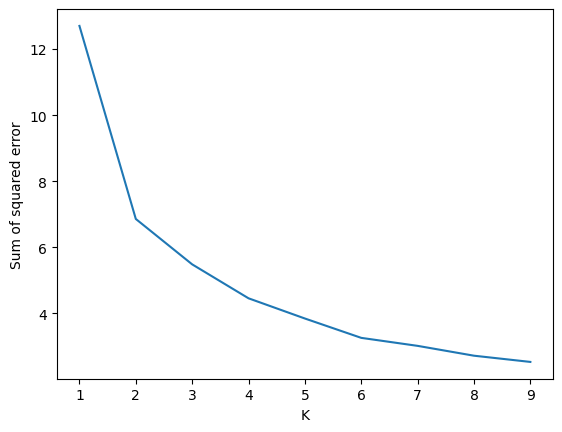

In [5]:
#look for elbow points
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng, sse)

In [6]:
#create 4 clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')

In [7]:
#assign each county a cluster
y_hc = hc.fit_predict(df[['Income','DSCI','PQ1','PQ2','PQ3','PQ4','TQ1','TQ2','TQ3','TQ4','Forest']])
df['cluster'] = y_hc
df.sort_values("cluster", inplace = True, ascending=True)

#average input vars by cluster
df_cluster = df.groupby('cluster').mean()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
<ipython-input-7-8f9cdfcf2ed6>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cluster = df.groupby('cluster').mean()


<Axes: ylabel='cluster'>

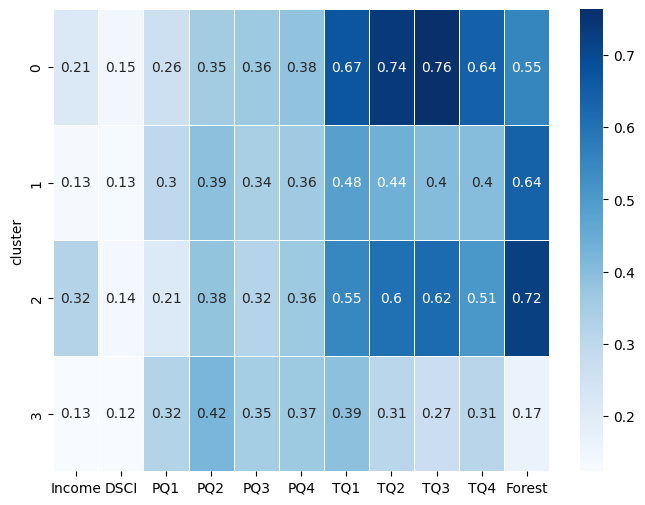

In [11]:
#heatmap of cluster characteristics
plt.figure(figsize=(8,6))
sns.heatmap(df_cluster, annot=True, cmap="Blues", linewidths=.5)

## Supervised Learning

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [13]:
# dropped 6 validation fips
df_drop = df.drop([51001, 51061, 51081, 51085, 51165, 51195])

In [14]:
#define input variables
input_var = df_drop[['Income','DSCI','PQ1','PQ2','PQ3','PQ4','TQ1','TQ2','TQ3','TQ4','Forest']]
X = input_var

y = df_drop['cluster']

In [15]:
#train test split (replace with specific columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [16]:
# validation
keep = [51001, 51061, 51081, 51085, 51165, 51195]
df_val = df.loc[keep]

cols_keep = ['Income',	'DSCI',	'PQ1',	'PQ2',	'PQ3',	'PQ4',	'TQ1',	'TQ2',	'TQ3',	'TQ4',	'Forest']
X_val = df_val[cols_keep]
y_val = df_val['cluster']

## RF

In [17]:
#create rf model (w 100 trees)
rf = RandomForestClassifier(n_estimators=100)

#fit model with training data
rf.fit(X_train, y_train)

RandomForestClassifier()

In [18]:
y_test.index

Int64Index([51121, 51147, 51003, 51057, 51115, 51141, 51059, 51135, 51047,
            51071, 51025, 51067, 51167, 51031, 51043, 51065, 51015, 51133,
            51007, 51111, 51029, 51077, 51107, 51053, 51041, 51153],
           dtype='int64', name='County')

In [19]:
#make predictions
y_pred = rf.predict(X_test)

for pred_label, true_label, index in zip(y_pred, y_test, y_test.index):
    print(pred_label, true_label, index)

0 0 51121
2 2 51147
0 2 51003
0 0 51057
1 3 51115
2 2 51141
2 0 51059
2 1 51135
1 1 51047
2 1 51071
0 2 51025
2 2 51067
2 2 51167
2 2 51031
1 1 51043
2 2 51065
0 0 51015
1 1 51133
0 0 51007
1 1 51111
1 1 51029
0 0 51077
1 3 51107
0 0 51053
1 1 51041
0 0 51153


In [20]:
from sklearn.metrics import classification_report

In [21]:
#assess model performance
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.75      0.75         8
           2       0.67      0.75      0.71         8
           3       0.00      0.00      0.00         2

    accuracy                           0.73        26
   macro avg       0.55      0.59      0.57        26
weighted avg       0.68      0.73      0.70        26



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
#feature importance
feature_imp = pd.DataFrame(rf.feature_importances_,index= X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_imp)

        importance
TQ3       0.198941
TQ4       0.189241
TQ2       0.171537
Forest    0.125707
TQ1       0.083231
Income    0.066390
PQ1       0.046004
PQ3       0.036731
PQ2       0.030697
DSCI      0.028629
PQ4       0.022892


## Logistic Regression

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [24]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# predict
y_pred = logreg_model.predict(X_test)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73         8
           1       0.71      0.62      0.67         8
           2       0.80      0.50      0.62         8
           3       0.00      0.00      0.00         2

    accuracy                           0.65        26
   macro avg       0.52      0.53      0.50        26
weighted avg       0.64      0.65      0.62        26



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6538461538461539


In [27]:
feature_names = X_train.columns

coeffs = logreg_model.coef_[0]

coeffs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})

coeffs_df['Abs_Coefficient'] = abs(coeffs_df['Coefficient'])
coeffs_df.sort_values(by='Abs_Coefficient', ascending=False)

,Feature,Coefficient,Abs_Coefficient
8,TQ3,1.723093,1.723093
7,TQ2,1.422466,1.422466
9,TQ4,1.322755,1.322755
6,TQ1,1.043657,1.043657
10,Forest,-1.024138,1.024138
3,PQ2,-0.268456,0.268456
4,PQ3,0.260597,0.260597
5,PQ4,0.208023,0.208023
0,Income,-0.118391,0.118391
1,DSCI,0.113849,0.113849


## Decision Tree

In [34]:
# supervised learning method
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [35]:
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.89      1.00      0.94         8
           2       0.83      0.62      0.71         8
           3       1.00      0.50      0.67         2

    accuracy                           0.81        26
   macro avg       0.86      0.75      0.77        26
weighted avg       0.82      0.81      0.80        26



In [36]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8076923076923077


In [37]:
cross_val_score(dt_model, X_train, y_train, cv=10)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


array([0.66666667, 1.        , 0.66666667, 0.66666667, 0.83333333,
       1.        , 0.83333333, 0.83333333, 0.8       , 1.        ])